<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics, losses
import tensorflow as tf
from keras import backend as K
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

In [ ]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Sampling Layer


We sample a point **z** from the latent distribution using the following equation:

z = z_mean + z_sigma * epsilon

where z_sigma = exp(z_log_var * 0.5) and epsilon ~ N(0, I)



In [ ]:
# creating new layer by subclassing Keras Layer class
# (can then be used in VAE network)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # The reparameterization Trick!

# Encoder


In [ ]:
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

# flatten layer is directly connected z_mean and z_log_var layers
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
# calling the sampling layer created above to sample from the latent space
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_4 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_3[0][0]']            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_4[0][0]']            
                                                                                            

# Decoder

In [ ]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation = 'relu', padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides = 1,
    activation="sigmoid",
    padding="same",
    name="decoder_output"
)(x)

decoder = models.Model(decoder_input, decoder_output)

# Creating VAE and training the VAE

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    # fucntion that outputs VAE output for prediction
    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(
    x_train,
    epochs=5,
    batch_size=100
)

Epoch 1/5
600/600 [==============================] - 206s 342ms/step - total_loss: 151.1842 - reconstruction_loss: 146.6524 - kl_loss: 4.5318
Epoch 2/5
600/600 [==============================] - 204s 339ms/step - total_loss: 134.3505 - reconstruction_loss: 129.4468 - kl_loss: 4.9038
Epoch 3/5
600/600 [==============================] - 197s 329ms/step - total_loss: 133.0324 - reconstruction_loss: 128.0298 - kl_loss: 5.0027
Epoch 4/5
600/600 [==============================] - 203s 339ms/step - total_loss: 132.2990 - reconstruction_loss: 127.2251 - kl_loss: 5.0741
Epoch 5/5
600/600 [==============================] - 188s 314ms/step - total_loss: 131.7088 - reconstruction_loss: 126.5556 - kl_loss: 5.1531


# Generating non-novel images

In [ ]:
example_images = x_test[:5000]
z_mean, z_log_var, reconstructions = vae.predict(example_images)

157/157 [==============================] - 9s 58ms/step


In [ ]:
reconstructions.shape

(5000, 32, 32, 1)

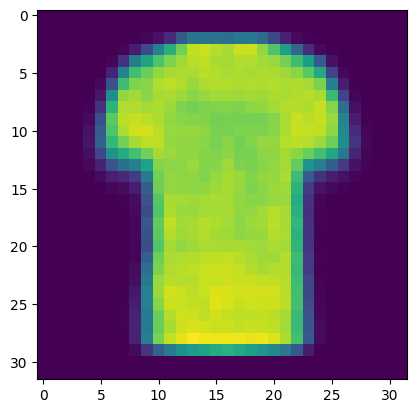

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(reconstructions[400, :, :, :])

# Visualizing the Latent Space

In [ ]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)

# Generating novel images using the decoder

In [ ]:
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 1s 670ms/step


In [ ]:
reconstructions.shape

(18, 32, 32, 1)

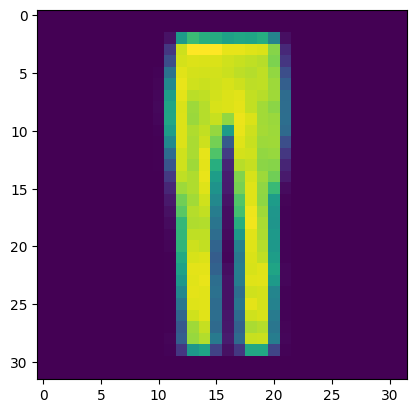

In [ ]:
plt.imshow(reconstructions[17, :, :, 0])

# Multi-Dimensional Latent Space VAE


---



# Loading Celeb Faces, Preprocess and imports

In [12]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset
!unzip -d dataset celeba-dataset.zip

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers
)

from scipy.stats import norm
import pandas as pd
import tensorflow_datasets as tfds

In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200 # latent space is 200 dimensional
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000 # weighting value applied to reconstruction loss
LOAD_MODEL = False

In [4]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [14]:
train_data = utils.image_dataset_from_directory(
    "dataset/img_align_celeba/img_align_celeba",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


In [15]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

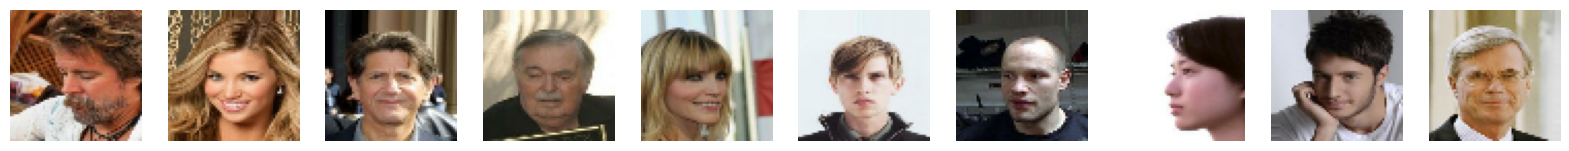

In [ ]:
train_sample = sample_batch(train)
display(train_sample, cmap=None)

# Creating Sampling Layer

This is the Sampling Layer used in the Encoder network to sample the point *z* from the normal distribution defined by *z_mean* and *z_log_var* through the use of the ["repramaterization trick"](https://arxiv.org/abs/1312.6114). Namely, we actually sample the point *epsilon* from a normal distribution and modify *epsilon* through the use of *z_mean* and *z_log_var*. Doing so allows for the gradients to be computed and backpropagated.

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim)) # sampling from a normal distribution
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Creating the Encoder

In [6]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['batch_normalization[0]

# Creating the Decoder

In [7]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 64)          36928     
 anspose)                                                    

# Creating the Variational AutoEncoder

In [8]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Function that calls the encoder-decoder network
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs) # input passed to encoder to output z sample
        reconstruction = decoder(z) # z sample passed to decoder to reconstruct input
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        # Forward propagation portion
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            # Calculation of reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            # Calculation of kl loss
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            # Calculation of total loss
            total_loss = reconstruction_loss + kl_loss

        # Backpropagation portion
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Metric update portion
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Training the Variational Autoencoder

In [ ]:
vae = VAE(encoder, decoder)
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)
# start
vae.fit(
    train,
    epochs=EPOCHS,
)
# Save the final models
vae.save("./drive/MyDrive/models/vae")
encoder.save("./drive/MyDrive/models/encoder")
decoder.save("./drive/MyDrive/models/decoder")

# Generating non-novel images

In [11]:
 vae = VAE(encoder, decoder)
 vae.load_weights("./drive/MyDrive/models/vae")
 encoder.load_weights("./drive/MyDrive/models/encoder")
 decoder.load_weights("./drive/MyDrive/models/decoder")

In [16]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 82ms/step
Example real faces


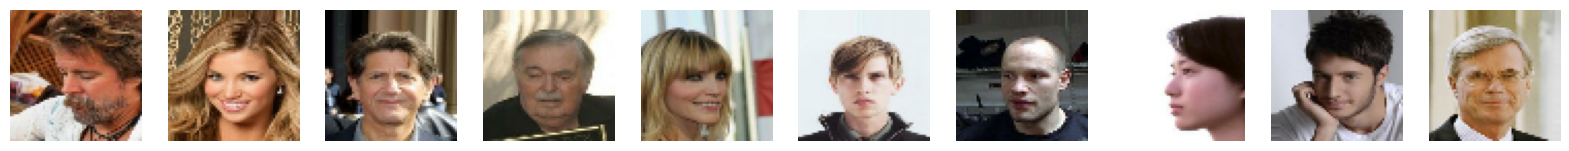

Reconstructions


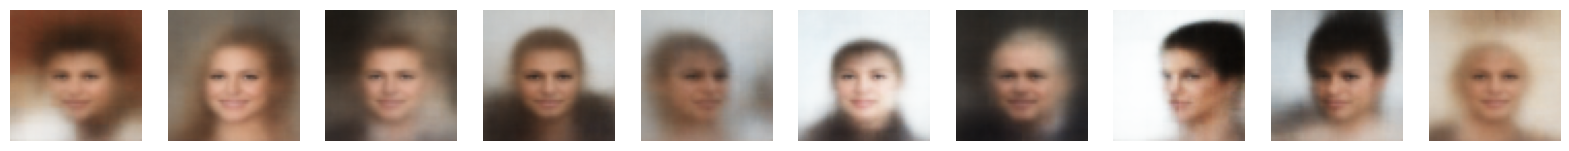

In [17]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Visualizing and Analyzing the Latent Space

To visualize the latent space we take the previous sample images from the previous section (i.e., images used to generate non-novel/reconstruction images) and input the 128 images into the encoder of the Variational Autoencoder. This outputs the sample matrix z representing the 128 images in 200 dimensional space.  

In [18]:
_, _, z = vae.encoder.predict(example_images)

4/4 [==============================] - 0s 13ms/step


Each instance of the 128 instances is a vector of 200 values (i.e., 200 dimensional)

In [19]:
z.shape

(128, 200)

As can be seen from the kernal density estimation each instance's latent space vector (i.e., the 200 values/dimensions) is basically centered at zero with a variance of positive/negative 2

<Axes: ylabel='Density'>

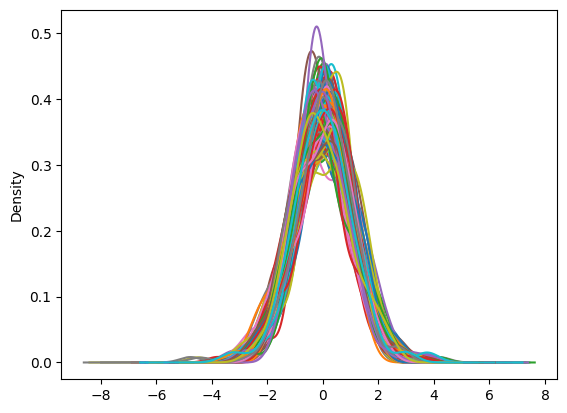

In [26]:
x=pd.DataFrame(z[:, :])
x.plot(kind='kde', legend=False)

As seen from the histograms and density curves each of the 200 dimensions for each of the 128 sample points of the latent space are basically normally distributed but some dimensions are more normally distributed (i.e., standard normal) versus others, indicating the BETA weight value should probably be decreased allowing the loss function to focus more attention on kl loss.

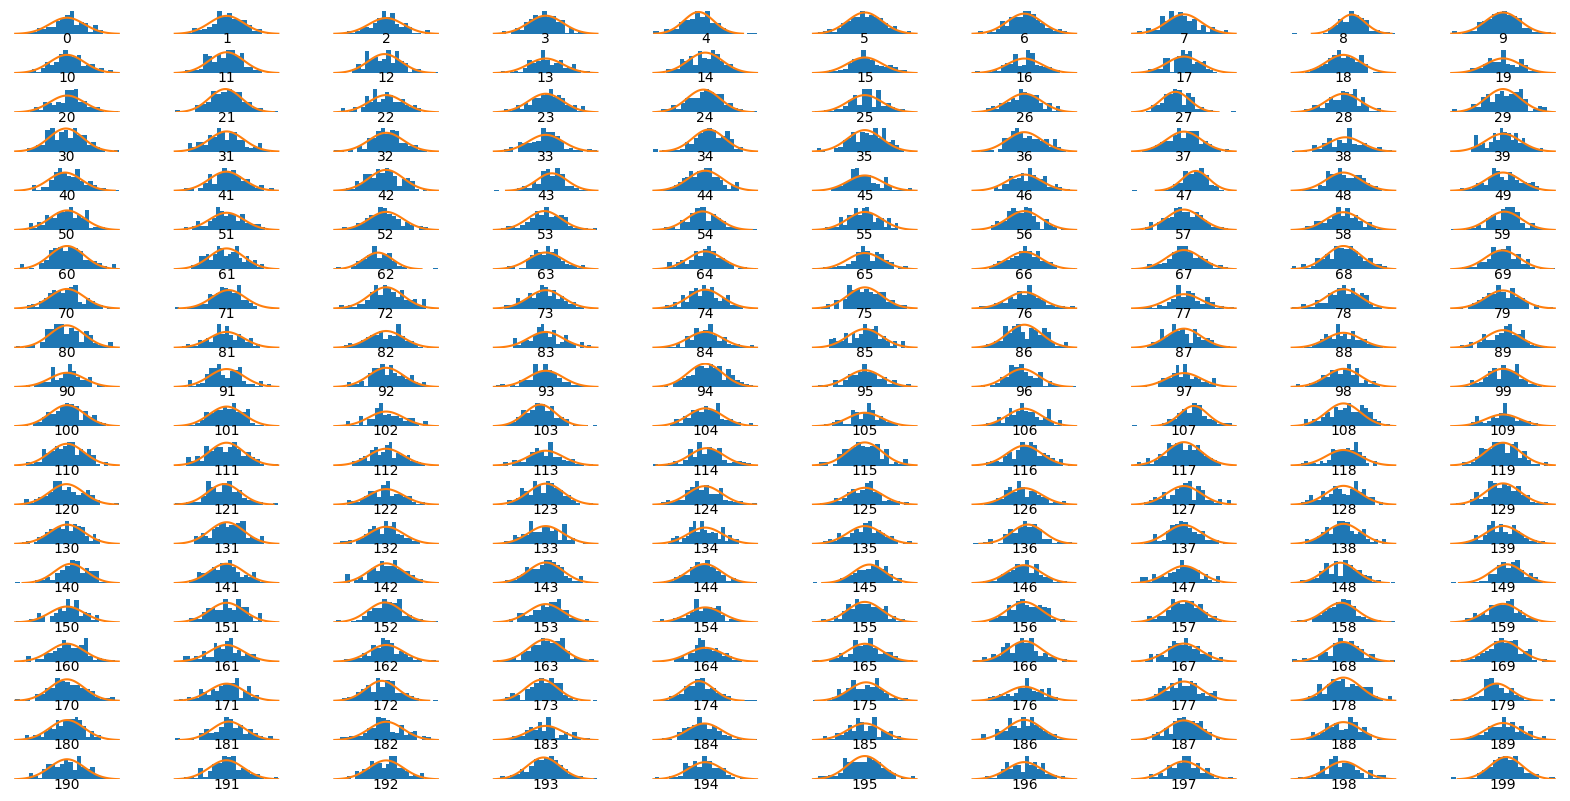

In [30]:
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(200):
    ax = fig.add_subplot(20, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

# Generating novel images using the decoder

These novel images are generated from a standard normal distribution (i.e., the z_sample) and DO NOT COME FROM THE INPUT IMAGES!!! The decoder will transform a standard random normal distribution into an image (in this case a human face, due to the weights of the VAE).

1/1 [==============================] - 1s 608ms/step


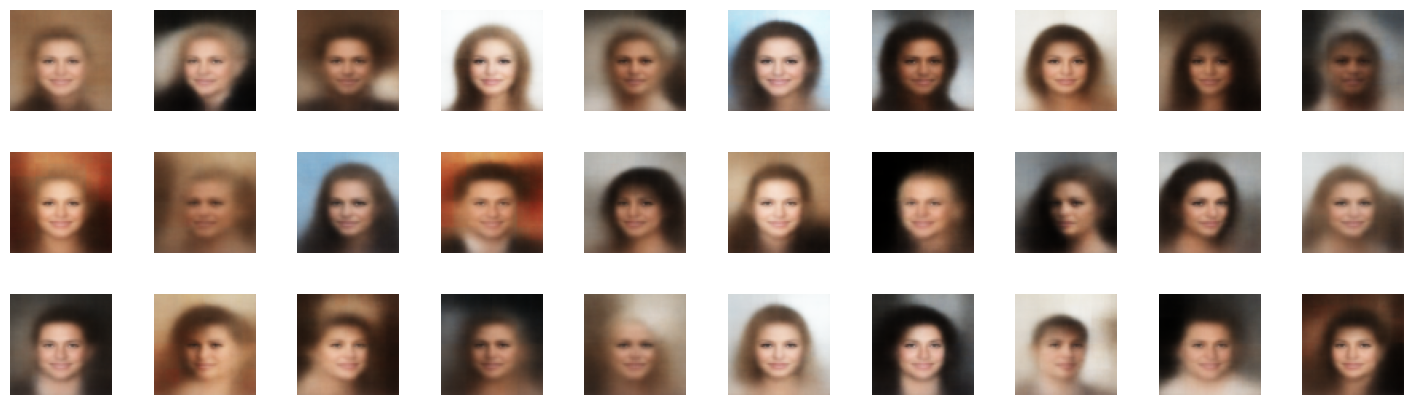

In [31]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
# Decode the sampled points
reconstructions = decoder.predict(z_sample)
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])